Import libraries

In [2]:
# import library
import argparse
import logging
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import cv2
import wandb
import numpy as np
# from evaluate import evaluate
# from unet import UNet
# from utils.data_loading import BasicDataset, CarvanaDataset
# from utils.dice_score import dice_loss

In [8]:
# dir_img = Path('./data/carvana-image-masking-challenge/train_hq/')
# dir_mask = Path('./data/carvana-image-masking-challenge/train_masks/')
# dir_img = Path(r'C:\Dante\code\dataset\detection\JPEGImages'.replace('\\', '/'))
# dir_xml = Path(r'C:\Dante\code\dataset\detection\Annotations'.replace('\\', '/'))
# dir_checkpoint = Path('./checkpoints/')
save_dir = Path('./checkpoints/')

Data loader

In [3]:
# import pathlib
# import xml.etree.ElementTree as ET
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
# from PIL import Image  # 引入 PIL 庫
# import matplotlib.pyplot as plt

# def parse_xml_annotation(xml_file):
#     """
#     解析 XML 標註文件，返回圖像文件名和 bounding box 資訊。
    
#     :param xml_file: XML 文件的路徑
#     :return: 包含文件名和 bounding box 的字典 {'file': 'image_name.jpg', 'bboxes': [[xmin, ymin, xmax, ymax], ...]}
#     """
#     tree = ET.parse(xml_file)
#     root = tree.getroot()

#     filename = root.find('filename').text
#     bboxes = []
    
#     for obj in root.findall('object'):
#         bndbox = obj.find('bndbox')
#         xmin = int(bndbox.find('xmin').text)
#         ymin = int(bndbox.find('ymin').text)
#         xmax = int(bndbox.find('xmax').text)
#         ymax = int(bndbox.find('ymax').text)
#         bboxes.append([xmin, ymin, xmax, ymax])
    
#     return {'file': filename, 'bboxes': bboxes}

# class UNetDatasetWithBoundingBoxes(Dataset):
#     def __init__(self, img_dir: str, xml_dir: str, transform = None, img_scale: float = 1.0, mask_suffix: str = ''):
#         """
#         :param img_dir: 圖片目錄的路徑
#         :param xml_dir: 標註 XML 文件的目錄
#         :param transform: 圖片轉換操作
#         :param img_scale: 圖片的目標大小 * scale
#         """
#         self.img_dir = img_dir
#         self.xml_dir = xml_dir
#         self.transform = transform
#         self.img_scale = img_scale
#         self.annotations = self.load_annotations()
#         self.mask_suffix = mask_suffix

#         return 
    
#     def load_annotations(self):
#         annotations = []
#         for xml_file in os.listdir(self.xml_dir):
#             if xml_file.endswith('.xml'):
#                 annotation = parse_xml_annotation(os.path.join(self.xml_dir, xml_file))
#                 annotations.append(annotation)
#         return annotations

#     def __len__(self):
#         return len(self.annotations)
    
#     def __getitem__(self, index):
#         # get bounding box
#         annotation = self.annotations[index]
#         img_path = os.path.join(self.img_dir, annotation['file'])     
#         bboxes = annotation['bboxes']

#         img = cv2.imread(img_path)
#         # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    # not necessary
#         mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)


#         # 使用每個 bounding box 畫出矩形
#         for bbox in bboxes:
#             xmin, ymin, xmax, ymax = bbox
#             cv2.rectangle(mask, (xmin, ymin), (xmax, ymax), color=1, thickness=-1) 
#             print(mask[0][0])

#         img = Image.fromarray(img)
#         mask = Image.fromarray(mask)

#         # 重新調整圖片和 mask 的大小
#         if self.transform is not None:
#             img = self.transform(img)
#             mask = self.transform(mask)

#         return {
#             'image': img,
#             'mask': mask
#         }


# dataset = UNetDatasetWithBoundingBoxes(dir_img, dir_xml)
# # dataset[0]['mask']

Data Loader
1. transfer xml and image to data
2. 

In [3]:
import os
import json
import cv2
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T

img_dir_path = r'C:\Dante\code\dataset_labelme\detection'.replace('\\', '/')

class Json2MaskDataset(Dataset):
    def __init__(self, json_dir, transform=None):
        self.json_dir = json_dir
        self.transform = transform

        # 讀取 JSON 文件 in dir
        self.json_files = [file for file in os.listdir(self.json_dir) if file.endswith('json')]
        if not self.json_files:
            raise ValueError(f"No JSON files found in folder: {json_dir}")

        self.data = []
        for json_file in self.json_files:
            with open(os.path.join(json_dir, json_file), 'r') as file:
                json_data = json.load(file)
                self.data.append(json_data)

    def __len__(self):
        return len(self.data)  

    def __getitem__(self, idx):

        data = self.data[idx]
        image_path = data["imagePath"]
        image_path = os.path.join(img_dir_path, os.path.relpath(image_path, start=".."))
        shapes = data["shapes"]
        image_height = data["imageHeight"]
        image_width = data["imageWidth"]

        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file not found: {image_path}")


        # 讀取影像
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 創建空的 mask
        mask = np.zeros((image_height, image_width), dtype=np.uint8)

        # 繪製多邊形 mask
        for shape in shapes:
            points = np.array(shape["points"], dtype=np.int32)
            cv2.fillPoly(mask, [points], color=1)

        # 轉換為 PIL 格式
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)

        # 應用轉換（如果有）
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # return {
        #     'image': image, 
        #     'mask': mask
        # }

        return image, mask

# # 構建數據集
data_transforms = T.Compose([T.Resize((256, 256)), T.ToTensor()])
# 定義數據增強操作
# data_transforms = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),  # 隨機水平翻轉
#     transforms.RandomVerticalFlip(p=0.5),    # 隨機垂直翻轉
#     transforms.RandomRotation(30),           # 隨機旋轉角度範圍 (-30, 30)
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 隨機調整亮度、對比度、飽和度和色調
#     transforms.RandomResizedCrop((256, 256), scale=(0.8, 1.0)),  # 隨機裁剪並調整大小
# ])

# # 構建數據集
# transform = T.Compose([T.Resize((256, 256)), T.ToTensor()])
json_dir = r'C:\Dante\code\dataset_labelme\detection\Annotationss'.replace('\\', '/')
dataset = Json2MaskDataset(json_dir, transform=data_transforms)

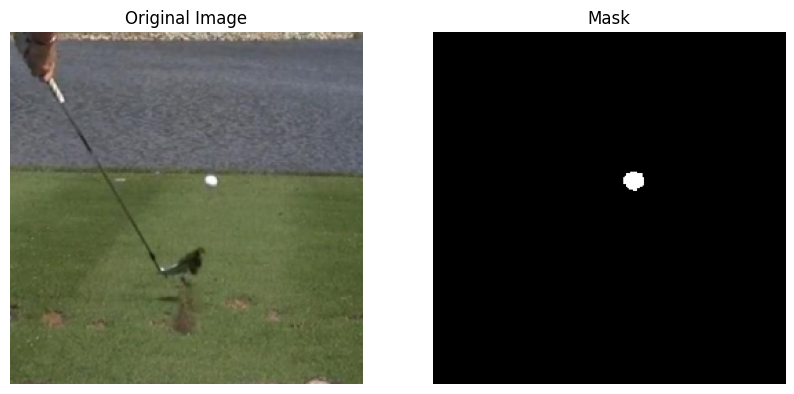

In [4]:
import matplotlib.pyplot as plt

# 顯示影像和 mask 的函數
def show_image_and_mask(dataset, index=0):
    # 獲取影像和 mask
    image, mask = dataset[index]
    
    # 將張量轉換為 NumPy 陣列
    image_np = image.permute(1, 2, 0).numpy()  # 調整維度順序，從 [C, H, W] 到 [H, W, C]
    mask_np = mask.squeeze().numpy()  # 移除多餘的維度

    # 顯示影像和 mask
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(image_np)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(mask_np, cmap='gray')
    axs[1].set_title('Mask')
    axs[1].axis('off')

    plt.show()

# 使用數據集
show_image_and_mask(dataset, index=8)  # 顯示數據集中的第一個影像和其 mask

Model

In [10]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()
        
        features = init_features
        # Contracting Path
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        # Expanding Path
        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        # Contracting Path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        # Expanding Path
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )


Training

In [24]:
import torch.optim as optim
from alive_progress import alive_bar  # 導入 alive-progress

# 初始化模型
model = UNet(in_channels=3, out_channels=1, init_features=64)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# 定義損失函數和優化器
criterion = nn.BCELoss()  # 二元交叉熵損失
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 訓練模型的部分代碼
num_epochs = 2000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # 使用 alive_bar 顯示進度條
    with alive_bar(len(dataset), title=f'Epoch {epoch+1}/{num_epochs}') as bar:
        for i, (inputs, masks) in enumerate(dataset):  # 使用你的數據集
            inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
            masks = masks.to('cuda' if torch.cuda.is_available() else 'cpu')

            # 檢查並調整輸入的維度
            if inputs.dim() == 3:  # 如果 inputs 是 3D 張量 (C, H, W)，將其轉換為 4D (1, C, H, W)
                inputs = inputs.unsqueeze(0)
            if masks.dim() == 3:  # 如果 masks 是 3D 張量 (H, W)，將其轉換為 4D (1, 1, H, W)
                masks = masks.unsqueeze(0).unsqueeze(0)
            elif masks.dim() == 5:  # 如果 masks 是 5D 張量 (1, 1, 1, H, W)，去掉多餘的維度
                masks = masks.squeeze(1)  # 去掉第 1 維度
            
            # 確保 masks 的大小與 outputs 匹配
            if masks.size() != inputs.size():
                masks = masks.squeeze(1)  # 繼續去掉多餘的維度，直到大小匹配

            # 零梯度
            optimizer.zero_grad()

            # 前向傳播
            outputs = model(inputs)

            # 計算損失
            loss = criterion(outputs, masks)
            
            # 反向傳播和優化
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            # 更新進度條
            bar()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataset)}")


Epoch 1/2000 |████████████████████████████████████████| 26/26 [100%] in 1.6s (16.60/s) 
Epoch 1/2000, Loss: 0.6161358035527743
Epoch 2/2000 |████████████████████████████████████████| 26/26 [100%] in 0.8s (33.82/s) 
Epoch 2/2000, Loss: 0.4879867205253014
Epoch 3/2000 |████████████████████████████████████████| 26/26 [100%] in 0.8s (33.62/s) 
Epoch 3/2000, Loss: 0.4017195174327263
Epoch 4/2000 |████████████████████████████████████████| 26/26 [100%] in 0.8s (33.64/s) 
Epoch 4/2000, Loss: 0.3478950032821068
Epoch 5/2000 |████████████████████████████████████████| 26/26 [100%] in 0.8s (33.59/s) 
Epoch 5/2000, Loss: 0.30906095527685606
Epoch 6/2000 |████████████████████████████████████████| 26/26 [100%] in 0.8s (33.07/s) 
Epoch 6/2000, Loss: 0.2831101314379619
Epoch 7/2000 |████████████████████████████████████████| 26/26 [100%] in 0.8s (33.88/s) 
Epoch 7/2000, Loss: 0.26284478260920596
Epoch 8/2000 |████████████████████████████████████████| 26/26 [100%] in 0.8s (33.02/s) 
Epoch 8/2000, Loss: 0

In [21]:
# model_path = os.path.join(save_dir, f"unet_epoch_{epoch+1}.pth")
model_path = os.path.join(save_dir, f"unet_epoch_01.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to checkpoints\unet_epoch.pth


Predict

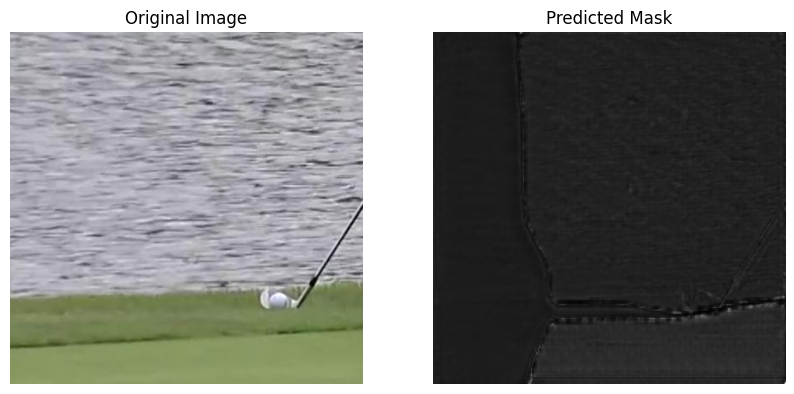

In [23]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

# 載入訓練好的模型
model = UNet(in_channels=3, out_channels=1, init_features=32)
# model = UNet(in_channels=3, out_channels=1)
model.load_state_dict(torch.load(r'C:\Dante\code\UNet\jupyter\checkpoints\unet_epoch_01.pth'.replace('\\', '/')))  # 載入模型權重
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()  # 設置模型為評估模式

# 定義影像的預處理
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

def predict_image(image_path, model, transform):
    # 載入影像
    # image = Image.open(image_path).convert('RGB')
    image = Image.open(image_path)
    input_image = transform(image).unsqueeze(0)  # 增加一個 batch 維度
    input_image = input_image.to('cuda' if torch.cuda.is_available() else 'cpu')

    # 預測
    with torch.no_grad():
        output = model(input_image)
        predicted_mask = output.squeeze().cpu().numpy()  # 去除 batch 和 channel 維度，轉回 NumPy 陣列

    return image, predicted_mask

def show_prediction(image_path, model, transform):
    # 預測影像的 mask
    original_image, predicted_mask = predict_image(image_path, model, transform)

    # 顯示影像和預測的 mask
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(predicted_mask, cmap='gray')
    axs[1].set_title('Predicted Mask')
    axs[1].axis('off')

    plt.show()

# 使用模型進行預測
image_path = r'C:\Dante\code\dataset_labelme\detection\JPEGImages\00101_00001.jpg'.replace('\\', '/')  # 替換為要預測的影像路徑
show_prediction(image_path, model, transform)
